In [15]:
from svgpathtools import parse_path, Line
import os
import re
import matplotlib.pyplot as plt
import cairosvg
from PIL import Image
import numpy as np
import cv2


folder_path = "/Users/frbuccoliero/Desktop/Thesis/Tests/utils/wikiCommonsOutput/"
svg_folder_path = os.path.join(folder_path, "svg")
png_folder_path = os.path.join(folder_path, "png")

img_paths = []

# Get all SVG files in the folder
for filename in sorted(os.listdir(svg_folder_path)):
	if filename.endswith(".svg"):
		svg_path = os.path.join(svg_folder_path, filename)
		output_name = os.path.splitext(filename)[0] + ".png"
		output_path = os.path.join(png_folder_path, output_name)
		img_paths.append((svg_path, output_path))

		try:
			cairosvg.svg2png(url=svg_path, write_to=output_path)
			print(f"Converted: {filename} -> {output_name}")
		except Exception as e:
			print(f"Failed to convert {filename}: {e}")

def complex_to_tuple(c):
    return (c.real, c.imag)


Converted: 1-1.svg -> 1-1.png
Converted: 1-2.svg -> 1-2.png
Converted: 1-3.svg -> 1-3.png
Converted: 1-4.svg -> 1-4.png
Converted: 1-5.svg -> 1-5.png
Converted: 1-6.svg -> 1-6.png
Converted: 5-2red.svg -> 5-2red.png
Converted: 5-2red_noir.svg -> 5-2red_noir.png
Converted: Aquatic-pollut-red.svg -> Aquatic-pollut-red.png
Converted: acid_red.svg -> acid_red.png
Converted: acide.svg -> acide.png
Converted: blan-red.svg -> blan-red.png
Converted: bleu4.svg -> bleu4.png
Converted: bottle.svg -> bottle.png
Converted: exclam.svg -> exclam.png
Converted: explos.svg -> explos.png
Converted: flamme.svg -> flamme.png
Converted: jaune5-1.svg -> jaune5-1.png
Converted: rondflam.svg -> rondflam.png
Converted: rouge2.svg -> rouge2.png
Converted: rouge2_noir.svg -> rouge2_noir.png
Converted: rouge3.svg -> rouge3.png
Converted: rouge3_noir.svg -> rouge3_noir.png
Converted: silhouete.svg -> silhouete.png
Converted: skull.svg -> skull.png
Converted: skull6.svg -> skull6.png
Converted: skull_2.svg -> skul

In [16]:
import xml.etree.ElementTree as ET

def extract_svg_lines(svg_path):
    tree = ET.parse(svg_path)
    root = tree.getroot()
    ns = {'svg': 'http://www.w3.org/2000/svg'}

    lines = []

    # Extract <line> elements
    for line in root.findall('.//svg:line', ns):
        x1 = float(line.attrib['x1'])
        y1 = float(line.attrib['y1'])
        x2 = float(line.attrib['x2'])
        y2 = float(line.attrib['y2'])
        lines.append(((x1, y1), (x2, y2)))

    # Extract <polyline> as a sequence of connected points
    for polyline in root.findall('.//svg:polyline', ns):
        points_str = polyline.attrib.get('points', '').strip()
        points = [tuple(map(float, re.split('[, ]+', pt))) for pt in points_str.strip().split() if pt]
        for i in range(len(points) - 1):
            lines.append((points[i], points[i + 1]))

    # Extract straight segments from <path> elements
    for path_elem in root.findall('.//svg:path', ns):
        d = path_elem.attrib.get('d')
        if not d:
            continue
        path = parse_path(d)
        for seg in path:
            if isinstance(seg, Line):
                start = (seg.start.real, seg.start.imag)
                end = (seg.end.real, seg.end.imag)
                lines.append((start, end))

    return lines

def get_svg_transform(svg_path, img_width, img_height):
    tree = ET.parse(svg_path)
    root = tree.getroot()
    svg_ns = {'svg': 'http://www.w3.org/2000/svg'}
    width = root.attrib.get('width', None)
    height = root.attrib.get('height', None)
    viewBox = root.attrib.get('viewBox', None)
    if viewBox:
        vb = list(map(float, viewBox.strip().split()))
        vb_x, vb_y, vb_w, vb_h = vb
    else:
        vb_x, vb_y, vb_w, vb_h = 0, 0, float(width), float(height)
    def svg_to_img_coords(x, y):
        px = (x - vb_x) * img_width / vb_w
        py = (y - vb_y) * img_height / vb_h
        return px, py
    return svg_to_img_coords


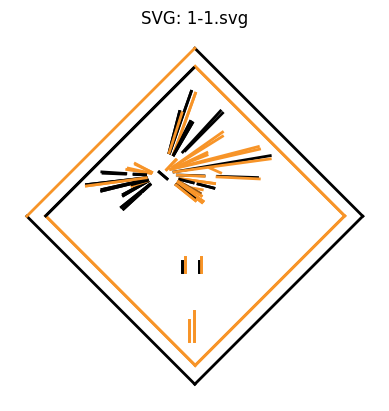

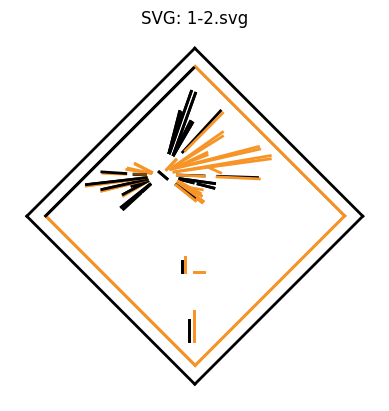

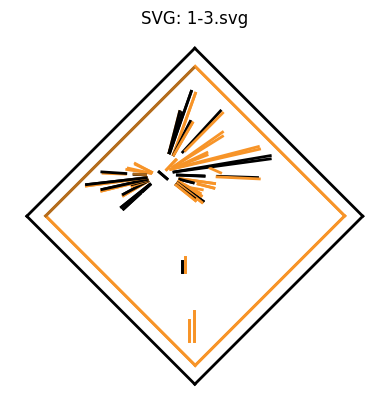

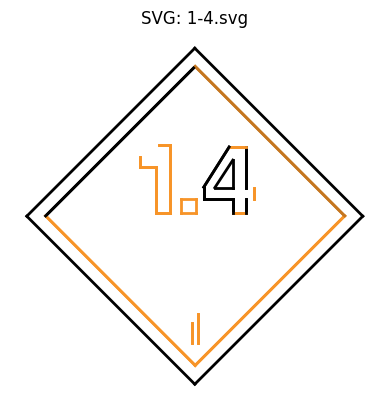

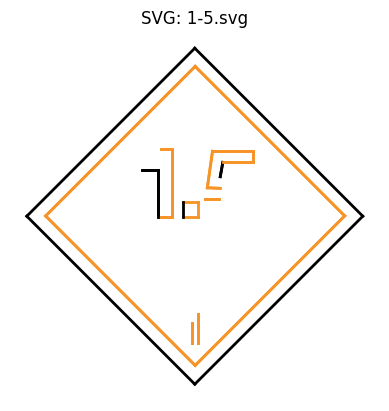

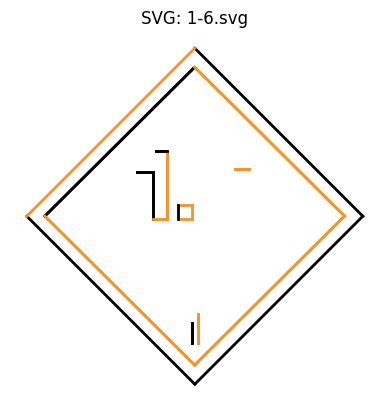

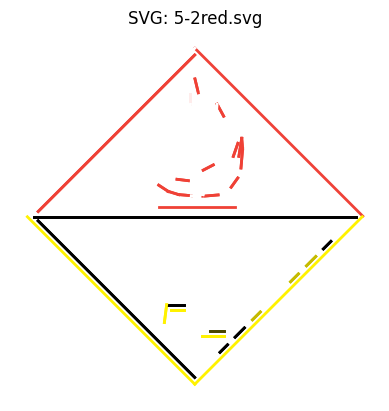

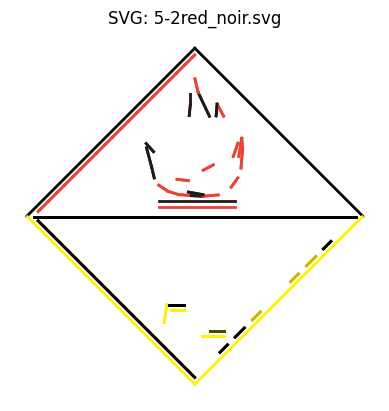

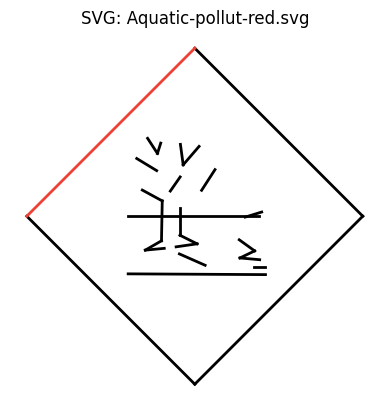

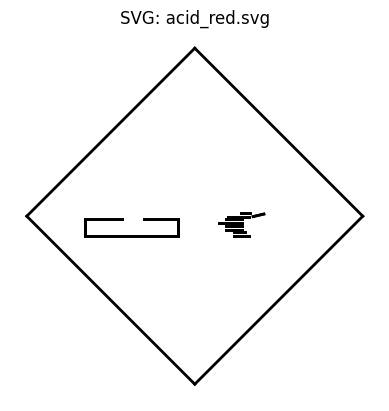

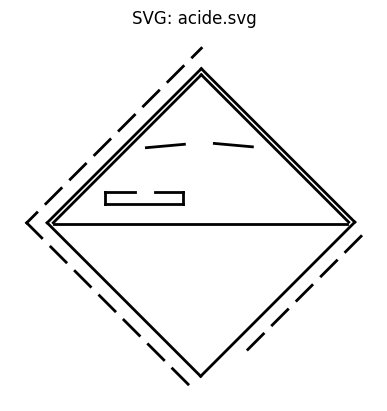

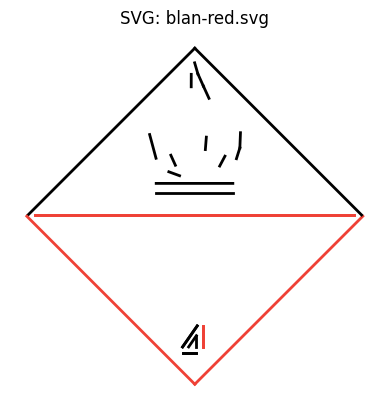

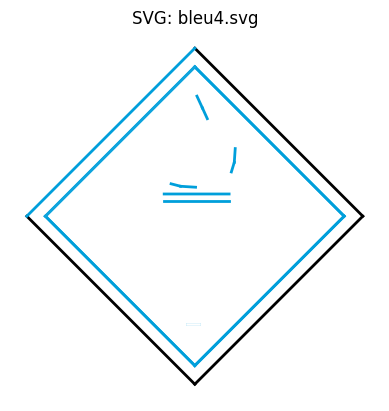

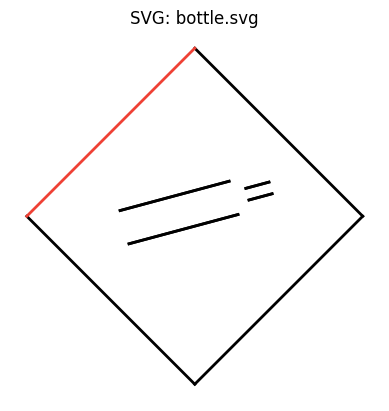

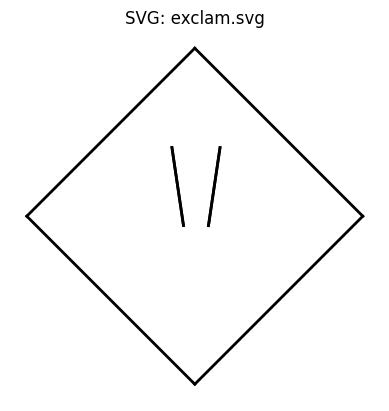

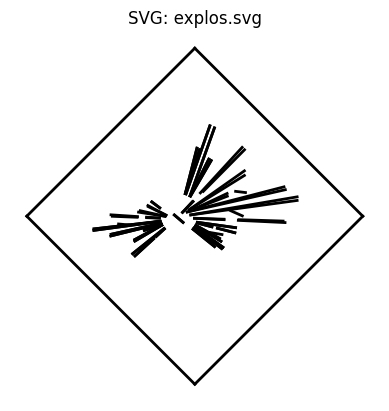

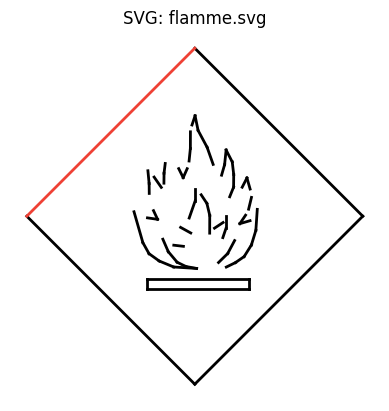

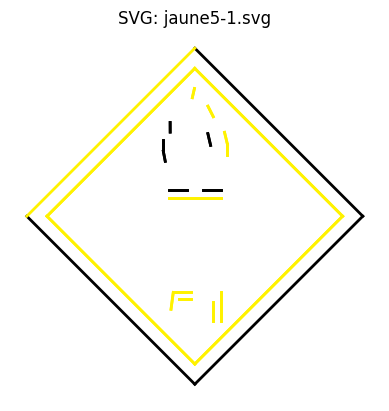

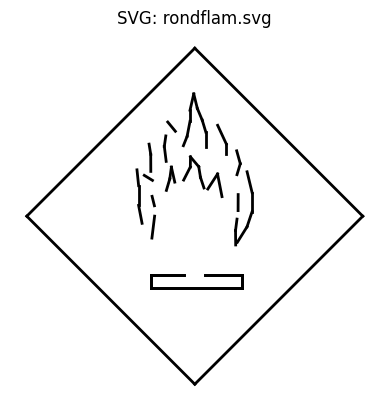

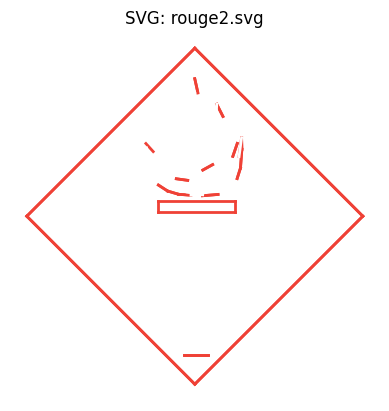

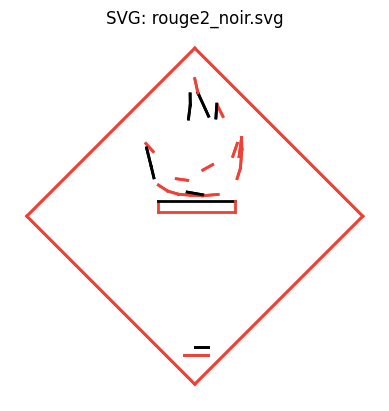

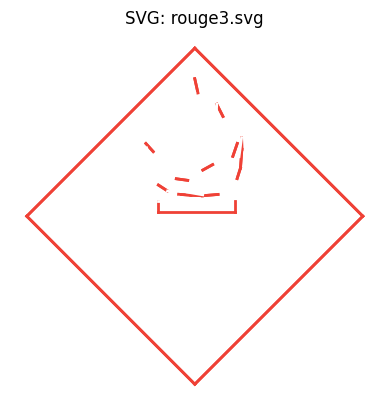

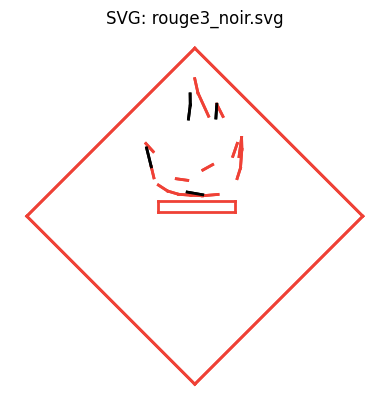

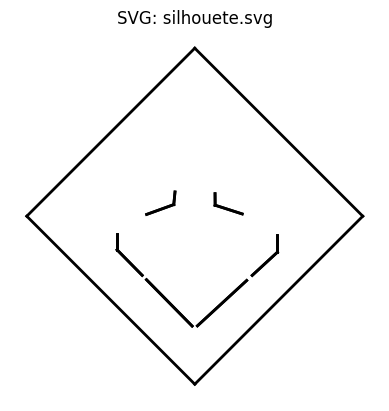

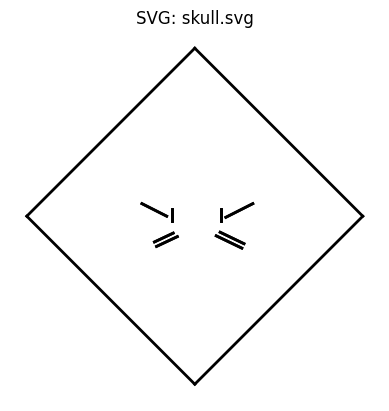

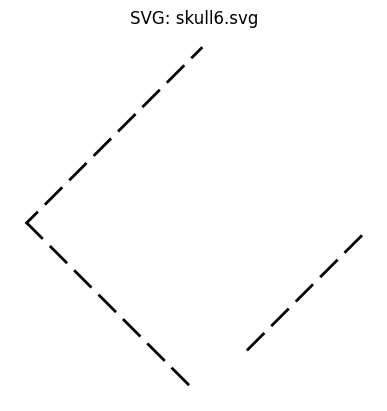

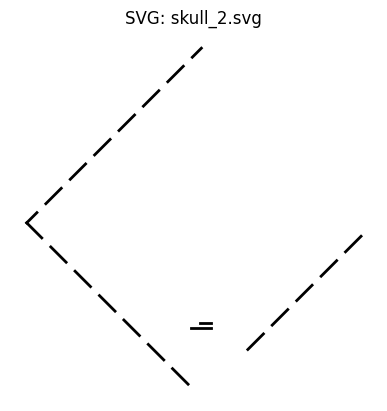

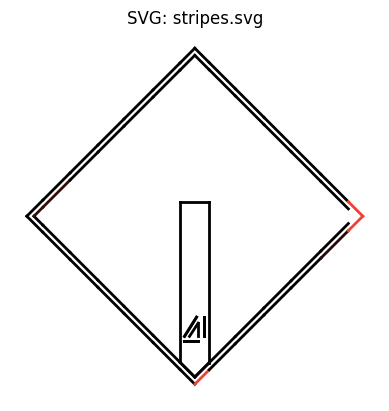

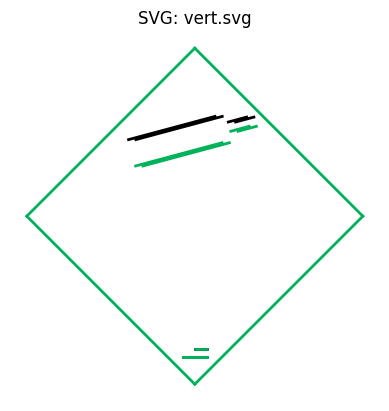

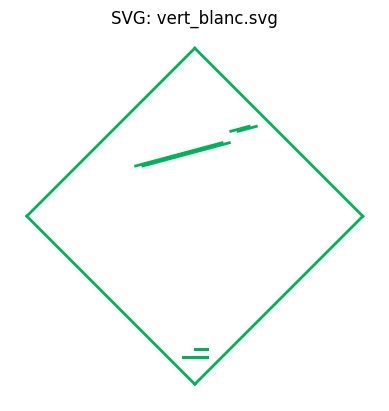

In [17]:
for svg_path, png_path in img_paths:
	line_segments = extract_svg_lines(svg_path)

	if not line_segments:
		print(f"No lines found in {svg_path}")
		continue

	# Load the corresponding PNG image
	img = Image.open(png_path).convert('RGB')
	img_np = np.array(img)
	height, width, _ = img_np.shape
	svg_to_img_coords = get_svg_transform(svg_path, width, height)

	fig, ax = plt.subplots(facecolor='white')
	ax.set_facecolor('white')

	all_xs, all_ys = [], []

	def get_neighborhood_color(x, y):
		# Convert SVG coordinates to image pixel coordinates
		px, py = svg_to_img_coords(x, y)
		px, py = int(round(px)), int(round(py))
		# 4-neighborhood offsets (up, down, left, right)
		offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
		colors = []
		for dx, dy in offsets:
			nx, ny = px + dx, py + dy
			if 0 <= nx < width and 0 <= ny < height:
				colors.append(tuple(img_np[ny, nx]))
		return colors

	for pt1, pt2 in line_segments:
		xs = [pt1[0], pt2[0]]
		ys = [-pt1[1], -pt2[1]]
		line_length = ((pt2[0] - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2) ** 0.5
		if line_length < 20:
			continue
		# Get 4-neighborhood colors for both endpoints
		colors1 = get_neighborhood_color(pt1[0], pt1[1])
		colors2 = get_neighborhood_color(pt2[0], pt2[1])
		all_colors = colors1 + colors2
		if all_colors:
			# Most frequent color among all 8 samples
			color = max(set(all_colors), key=all_colors.count)
		else:
			print(f"No colors found for line segment: {pt1} to {pt2}")
			color = (0, 0, 0)
		ax.plot(xs, ys, color=np.array(color)/255, linewidth=2)
		all_xs.extend(xs)
		all_ys.extend(ys)

	ax.set_aspect('equal')
	plt.axis('off')
	plt.title(f"SVG: {os.path.basename(svg_path)}")
	plt.show()


In [18]:
image = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00003.jpeg"
# image = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates/GHS_00012.png"
image = cv2.imread(image, cv2.IMREAD_COLOR_RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

scale = 1
image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

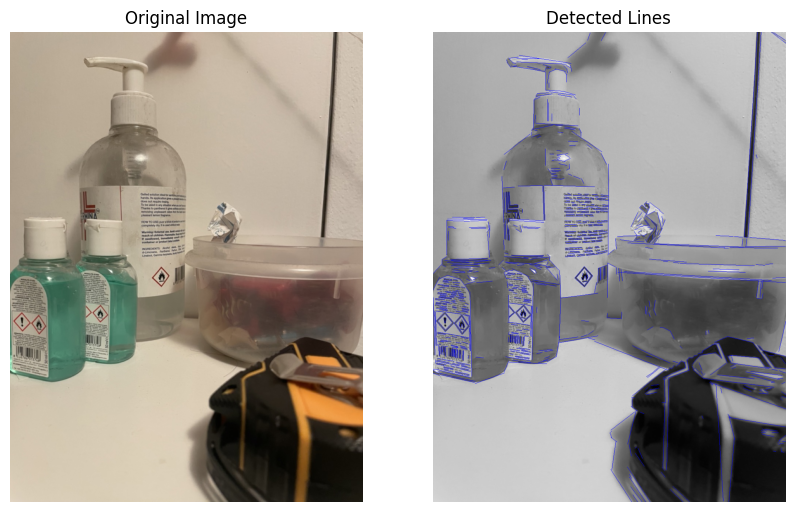

In [ ]:
detector = cv2.createLineSegmentDetector(0)
lines = detector.detect(gray)[0]

drawn_img = detector.drawSegments(gray,lines)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(122)
plt.imshow(drawn_img, cmap='gray')
plt.title("Detected Lines")
plt.axis('off')
plt.show()

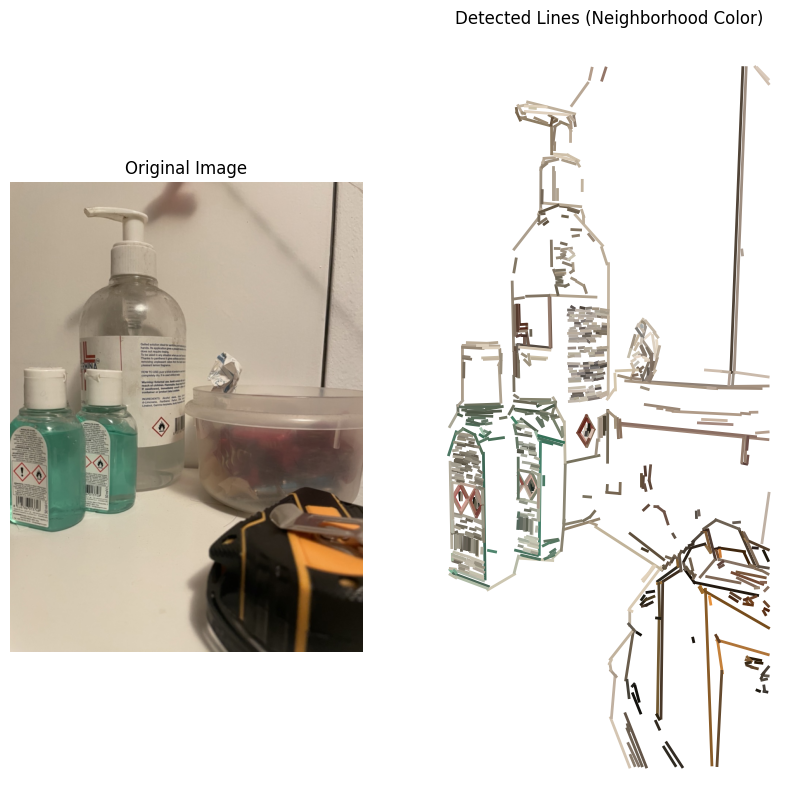

In [20]:

def get_8_neigh_colors(img, x, y):
    h, w = img.shape[:2]
    px, py = int(round(x)), int(round(y))
    offsets = [(-1, -1), (0, -1), (1, -1),
               (-1,  0),          (1,  0),
               (-1,  1), (0,  1), (1,  1)]
    colors = []
    for dx, dy in offsets:
        nx, ny = px + dx, py + dy
        if 0 <= nx < w and 0 <= ny < h:
            colors.append(tuple(img[ny, nx]))
    return colors

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

drawn_img = image.copy()
plt.subplot(122)
for line in lines:
    x1, y1, x2, y2 = line[0]
    colors1 = get_8_neigh_colors(image, x1, y1)
    colors2 = get_8_neigh_colors(image, x2, y2)
    all_colors = colors1 + colors2
    if all_colors:
        color = max(set(all_colors), key=all_colors.count)
    else:
        color = (0, 0, 0)
    color_rgb = (color[0]/255, color[1]/255, color[2]/255)
    plt.plot([x1, x2], [image.shape[0]- 1 - y1, image.shape[0] -1 -y2], color=color_rgb, linewidth=2)
plt.title("Detected Lines (Neighborhood Color)")
plt.axis('off')
plt.show()